This notebook generates a graph of connection of different entities related to Tencent.
Reference to the tutorial created by Andy Trick in http://andrewtrick.com/stormlight_network.html

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, permutations

In [4]:
input_file = pd.read_excel("/content/drive/MyDrive/GitHub/result_tencent_with_Prediction_v3.xlsx", sheet_name="Relation Graph")
entities = input_file['newNER']
relations = input_file['result vlookup']
e1 = input_file['Entity1']
e2 = input_file['Entity2']

In [5]:
#extract and create list of unique entities, store in uniqueE
entitiesToList = []
uniqueE = []
for i in range(len(entities)):
  iList = [e1[i],e2[i]]
  entitiesToList.append(iList)

  for j in iList:
    if j not in uniqueE:
      uniqueE.append(j)

#create combinations of entities 
combinationsOfUniqE = combinations(uniqueE, 2)
combDictionary = dict.fromkeys(combinationsOfUniqE,0)

EnR = pd.DataFrame({'entities': entitiesToList,
                   'relations': input_file['result vlookup']})

#filter away "Other"
noOtherEnR = EnR[EnR['relations'] != "Other"]

#sameEntity only 
sameEntity = EnR[EnR['relations'] == "Same-Entity(e1,e2)"]

#for each entity in entities, permutate order, change permutations to tuple then look for key match in combDictionary
#if have match: value +1 
for i in noOtherEnR['entities']:
  Ipermu = permutations(i)
  for j in Ipermu:
    jTup = tuple(j)
    if jTup in combDictionary:
      combDictionary[jTup] += 1

#permutate order, change perm to tuple and store in list 
sameETupList = []
for i in sameEntity['entities']:
  Ipermu = permutations(i)
  for j in Ipermu:
    jTup = tuple(j)
    sameETupList.append(jTup)


#Delete keys with value of 0 (relation with no instances)
usefulCombDictionary = {k:v for k,v in combDictionary.items() if v != 0}

#Generate entityDictionary to count entity occurance
entityDictionary = dict.fromkeys(uniqueE,0)

#Generate list to store colours
colourList = []

#Generate edgeList where all relations are formatted as (entity1, entity2, coOccurance)
edgeList = []

for item in usefulCombDictionary:
  genTuple = item + (usefulCombDictionary[item],)
  edgeList.append(genTuple)
  if item in sameETupList:
    colourList.append('r')
  else:
    colourList.append('g')

  #tally total occurance of entities and store in entityDictionary
  for i in item: 
    entityDictionary[i] += usefulCombDictionary[item]

edgeColorDict = dict(zip(usefulCombDictionary, colourList))
#Delete keys with value of 0 (entities with no instances)
usefulEntityDictionary = {k:v for k,v in entityDictionary.items() if v != 0}

#Generate list nodeList where all entities are formatted as (entity, totalOccurances)
nodeList = []
usefulEntities = []
for entity in usefulEntityDictionary:
  genTuple = (entity, usefulEntityDictionary[entity])
  nodeList.append(genTuple)
  usefulEntities.append(entity)

In [6]:
#set canvas size
fig = plt.figure(figsize=(20,20))
#print(edgeList)
#print(sameETupList)

#networkx graph time!
G = nx.Graph()
for i in sorted(nodeList):
    G.add_node(i[0], size = i[1])
G.add_weighted_edges_from(edgeList)

#check data of graphs
#G.nodes(data=True)
#G.edges(data = True)

#manually copy and pasted the node order using 'nx.nodes(G)'
#Couldn't determine another route to listing out the order of nodes for future work
nodeOrder = usefulEntities

#reorder node list
updatedNodeOrder = []
for i in nodeOrder:
    for x in nodeList:
        if x[0] == i:
            updatedNodeOrder.append(x)
       
#reorder edge list - this was a pain
test = nx.get_edge_attributes(G, 'weight')
updatedEdges = []
#updatedColours = []
for i in nx.edges(G):
    for x in test:
        if i[0] == x[0] and i[1] == x[1]:
            updatedEdges.append(test[x])
            #solve this: find new position of edge 
            #updatedColours.append(colourList[test[x]])

<Figure size 1440x1440 with 0 Axes>

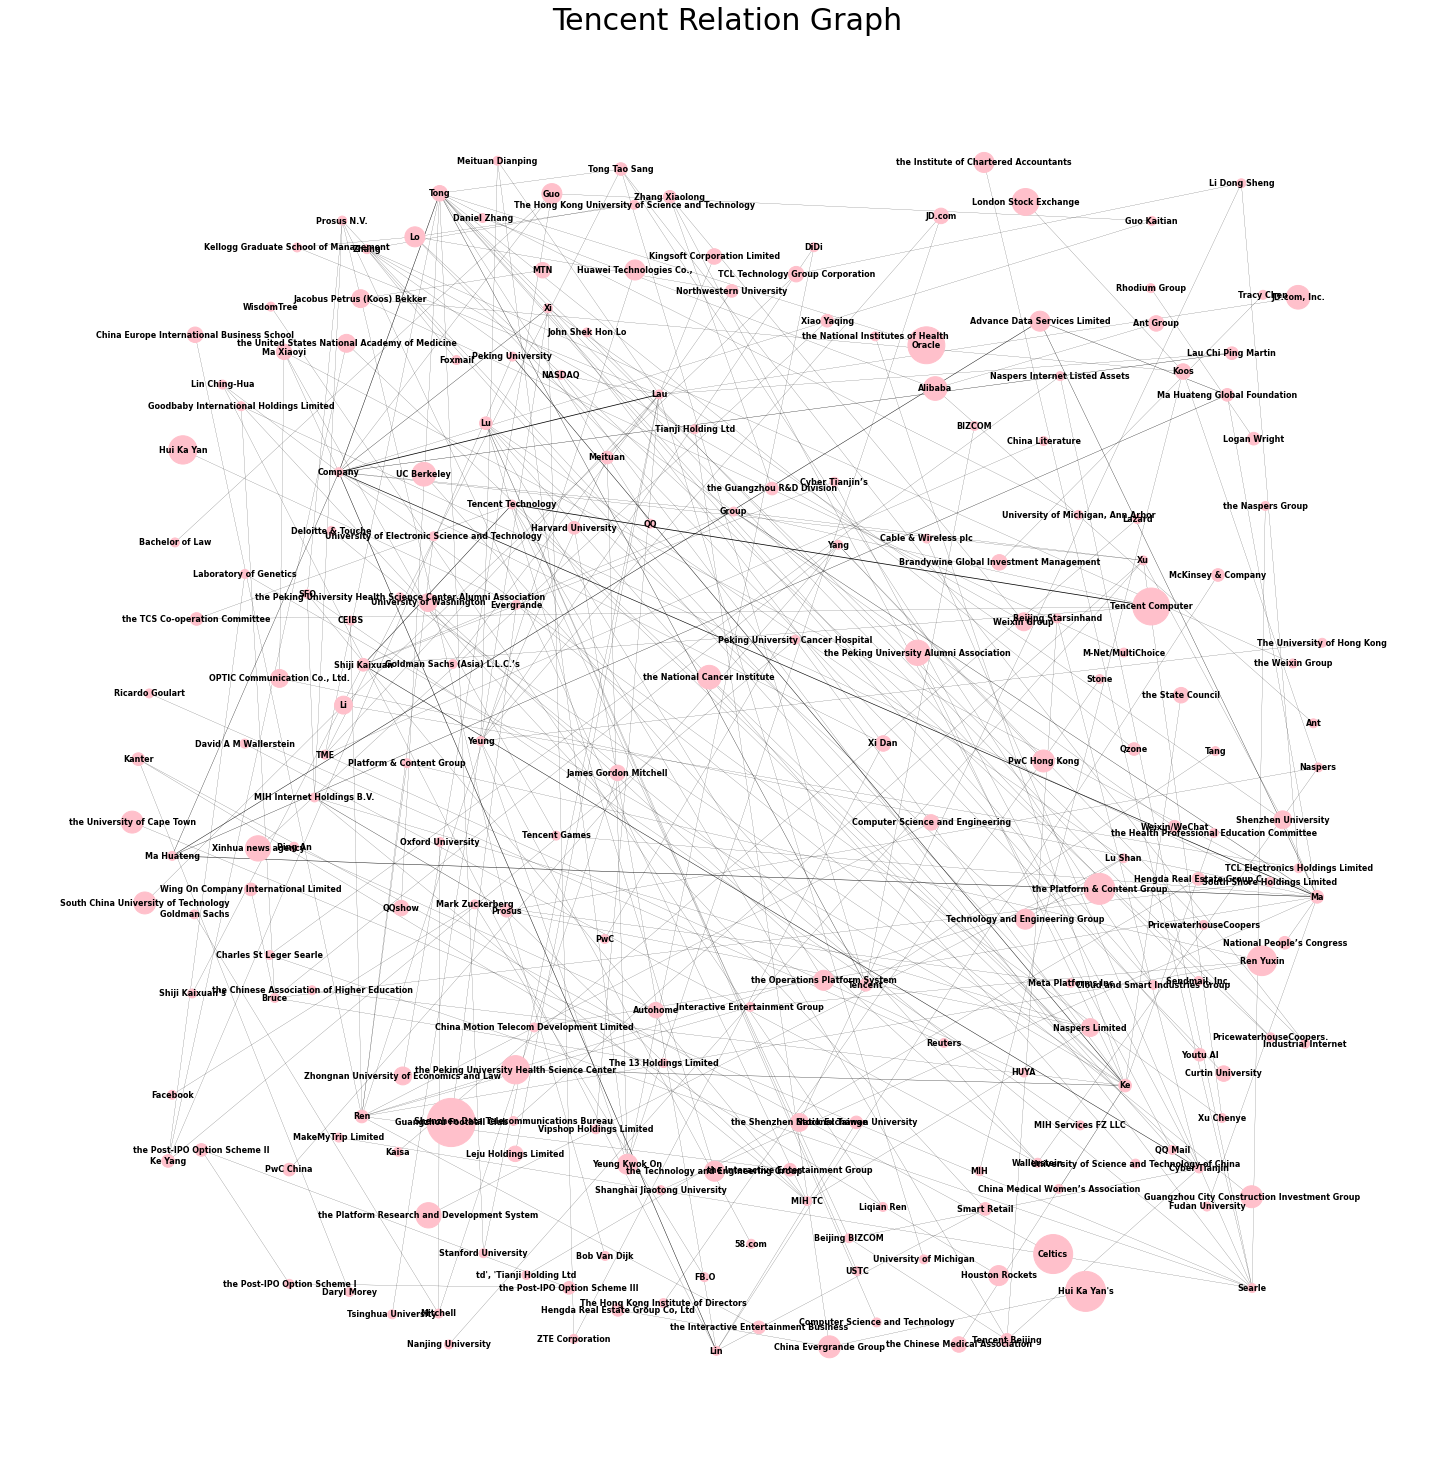

<Figure size 432x288 with 0 Axes>

In [11]:
#drawing customization
node_scalar = 80 #800
edge_scalar = 0.15
sizes = [x[1]*node_scalar for x in updatedNodeOrder]
widths = [x*edge_scalar for x in updatedEdges]

#draw the graph
pos = nx.spring_layout(G, k=99, iterations=2) #k=0.42, iterations=17

fig = plt.figure(figsize=(20,20))

nx.draw(G, pos, node_color='pink', with_labels=True, font_size = 8, font_weight = 'bold', 
        node_size = sizes, width = widths) # edge_color=colors


plt.title("Tencent Relation Graph", {'fontsize': '30'})
plt.show()
#plt.axis('off')

plt.savefig("/content/drive/MyDrive/GitHub/TencentGraph.png")